### Import library

In [1]:
import re
import csv
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy 
import spacy
from spacy import displacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Import data

In [2]:
df = pd.read_pickle("data/allNews_30%sample_lemmatized.pkl")

### Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [3]:
# Create Dictionary
id2word = corpora.Dictionary(df.content.tolist())

# Create Corpus
texts = df.content.tolist()

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 3), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 2), (57, 7), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 2), (64, 2), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 2), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 5), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency). For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 14 occurs three times and so on. This is used as the input by the LDA model. To see what word a given id corresponds to, pass the id as a key to the dictionary.

In [4]:
print(len(corpus))

42771


In [5]:
id2word[0]

'ability'

You can see a human-readable form of the corpus itself.

In [6]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('accomplished', 1),
  ('acknowledge', 1),
  ('address', 1),
  ('adviser', 1),
  ('advocacy', 1),
  ('aim', 1),
  ('aloud', 1),
  ('andrea', 1),
  ('angela_merkel', 1),
  ('answer', 1),
  ('anything', 1),
  ('appearance', 1),
  ('attitude', 1),
  ('audience', 3),
  ('barely_audible', 1),
  ('begin', 1),
  ('behavior', 1),
  ('belief', 1),
  ('berlin', 2),
  ('boo', 3),
  ('browser', 1),
  ('business', 2),
  ('campaign', 1),
  ('care', 1),
  ('certainly', 1),
  ('champion', 1),
  ('christine_lagarde', 1),
  ('clip', 1),
  ('come', 1),
  ('comment', 1),
  ('compel', 1),
  ('conference', 1),
  ('conviction', 1),
  ('convince', 1),
  ('country', 1),
  ('criticism', 1),
  ('crowd', 1),
  ('daily', 1),
  ('daughter', 2),
  ('decad', 1),
  ('defense', 1),
  ('derisive', 1),
  ('die_welt', 1),
  ('director', 1),
  ('display', 1),
  ('editor', 2),
  ('elect', 1),
  ('election', 1),
  ('elicit', 1),
  ('empowerer', 1),
  ('enable', 1),
  ('equality', 1),
  ('even', 1),
  ('ex

### How to find the optimal number of topics for LDA

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [8]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [9]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df.content.tolist(), start=2, limit=25, step=3)

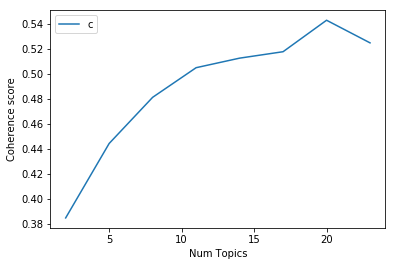

In [10]:
# Show graph
limit=26; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 10 topics itself.

In [11]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3846
Num Topics = 5  has Coherence Value of 0.4442
Num Topics = 8  has Coherence Value of 0.4812
Num Topics = 11  has Coherence Value of 0.505
Num Topics = 14  has Coherence Value of 0.5126
Num Topics = 17  has Coherence Value of 0.5178
Num Topics = 20  has Coherence Value of 0.543
Num Topics = 23  has Coherence Value of 0.5249


### Building the Topic Model

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [12]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### View the topics in LDA model

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

We can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"say" + 0.019*"woman" + 0.012*"man" + 0.008*"family" + 0.008*"black" '
  '+ 0.007*"people" + 0.007*"life" + 0.006*"child" + 0.006*"tell" + '
  '0.006*"medium"'),
 (1,
  '0.013*"show" + 0.011*"new" + 0.008*"film" + 0.006*"movie" + 0.006*"star" + '
  '0.005*"song" + 0.005*"music" + 0.005*"love" + 0.005*"book" + 0.005*"story"'),
 (2,
  '0.021*"say" + 0.008*"year" + 0.007*"get" + 0.007*"game" + 0.007*"go" + '
  '0.007*"day" + 0.007*"first" + 0.006*"team" + 0.006*"time" + 0.005*"last"'),
 (3,
  '0.020*"company" + 0.018*"say" + 0.010*"year" + 0.009*"new" + '
  '0.009*"percent" + 0.007*"market" + 0.007*"business" + 0.006*"price" + '
  '0.005*"last" + 0.005*"also"'),
 (4,
  '0.034*"say" + 0.016*"police" + 0.011*"city" + 0.009*"officer" + '
  '0.008*"report" + 0.008*"people" + 0.006*"kill" + 0.006*"gun" + 0.006*"tell" '
  '+ 0.006*"accord"'),
 (5,
  '0.016*"say" + 0.009*"law" + 0.009*"court" + 0.009*"report" + '
  '0.008*"government" + 0.008*"state" + 0.008*"president" + 0.007*"de

Topic 0 is a represented as _0.014"say" + 0.014"state" + 0.011"case" + 0.010"court" + 0.010"law" + 
  0.009"report" + 0.008"federal" + 0.007"school" + 0.007"department" + 0.006"student".

It means the top 10 keywords that contribute to this topic are: ‘say’, ‘state’, ‘case’.. and so on and the weight of ‘state’ on topic 0 is 0.014.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, we can guess what this topic could be, we may summarise the topic as 'law case about school'.

Likewise, we go through the remaining topic keywords and judge what the topic is.

### Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df.content.tolist(), dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.372810411395296

Coherence Score:  0.4484531556764312


### Visualize the topics-keywords

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.057976 -0.139436       1        1  20.491501
9      0.091627  0.050089       2        1  13.100780
2     -0.133369 -0.021160       3        1  10.035639
0     -0.115814  0.177934       4        1   9.627728
5      0.133997  0.078182       5        1   9.515670
3      0.093759 -0.173718       6        1   8.358624
4      0.045361  0.151448       7        1   8.060974
7      0.101403 -0.177185       8        1   7.503815
8      0.172133  0.079185       9        1   7.460663
1     -0.331121 -0.025338      10        1   5.844611, topic_info=      Category           Freq        Term          Total  loglift  logprob
term                                                                      
153    Default  140529.000000       trump  140529.000000  30.0000  30.0000
127    Default  247912.000000         say  247912.000000  29.0000  29.0000
2004   Default   34130.000000  republican   34130.000000  28.0000  28.0000
1006   Default   25748.000000     company   25748.000000  27.0000  27.0000
163    Default   31288.000000       woman   31288.000000  26.0000  26.0000
324    Default   52839.000000   president   52839.000000  25.0000  25.0000
367    Default   67886.000000       state   67886.000000  24.0000  24.0000
2806   Default   20889.000000      police   20889.000000  23.0000  23.0000
145    Default   37736.000000       think   37736.000000  22.0000  22.0000
775    Default   73686.000000      people   73686.000000  21.0000  21.0000
23     Default   27423.000000    campaign   27423.000000  20.0000  20.0000
211    Default   23216.000000     clinton   23216.000000  19.0000  19.0000
267    Default   65546.000000          go   65546.000000  18.0000  18.0000
386    Default   20887.000000        vote   20887.000000  17.0000  17.0000
48     Default   22088.000000    election   22088.000000  16.0000  16.0000
1375   Default   28537.000000     percent   28537.000000  15.0000  15.0000
265    Default   57330.000000         get   57330.000000  14.0000  14.0000
80     Default   27906.000000         man   27906.000000  13.0000  13.0000
269    Default   28640.000000  government   28640.000000  12.0000  12.0000
144    Default   24672.000000       thing   24672.000000  11.0000  11.0000
969    Default   32291.000000         way   32291.000000  10.0000  10.0000
35     Default   33763.000000     country   33763.000000   9.0000   9.0000
1663   Default   21718.000000      attack   21718.000000   8.0000   8.0000
288    Default   20619.000000         law   20619.000000   7.0000   7.0000
830    Default   36135.000000      report   36135.000000   6.0000   6.0000
2420   Default   14855.000000       court   14855.000000   5.0000   5.0000
131    Default   30354.000000        show   30354.000000   4.0000   4.0000
2408   Default   21396.000000        city   21396.000000   3.0000   3.0000
1095   Default   16153.000000      school   16153.000000   2.0000   2.0000
1931   Default   22350.000000    official   22350.000000   1.0000   1.0000
...        ...            ...         ...            ...      ...      ...
2875   Topic10    2922.220215       actor    3115.820801   2.7755  -5.7546
909    Topic10    5318.358887        star    6220.909668   2.6829  -5.1558
1236   Topic10    1562.749146      prince    1649.428955   2.7857  -6.3805
3416   Topic10    3810.759521          tv    4542.112793   2.6641  -5.4891
385    Topic10    1464.453857      viewer    1596.522339   2.7533  -6.4455
10567  Topic10    1270.561157     classic    1393.507324   2.7473  -6.5875
4360   Topic10    1901.107056       award    2377.599609   2.6160  -6.1845
131    Topic10   12349.901367        show   30354.492188   1.9404  -4.3133
3753   Topic10    4671.864258        book    8400.376953   2.2529  -5.2854
3574   Topic10    3817.633545      series    6354.056641   2.3302  -5.4873
587    Topic10    3034.097656     feature    4730.815430   2.3955  -5.7171
14     To

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

In [25]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=df.content.tolist(), dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('trump', 0.03350091453646005),
   ('president', 0.018344609982169052),
   ('house', 0.01008648224592338),
   ('report', 0.009097949512989579),
   ('news', 0.009028263702601076),
   ('administration', 0.008641040488174247),
   ('official', 0.007704233305219539),
   ('email', 0.006824898955574936),
   ('white', 0.006728631959780511),
   ('department', 0.005945564605930334)]),
 (1,
  [('state', 0.01563008104944518),
   ('country', 0.012271996147223215),
   ('attack', 0.011196768789016095),
   ('government', 0.00959193012040655),
   ('united', 0.009481351934718132),
   ('military', 0.008128224136162486),
   ('force', 0.0075018569132826955),
   ('war', 0.006978792995453927),
   ('group', 0.006361883117402751),
   ('president', 0.006292771751347489)]),
 (2,
  [('people', 0.0181462055536172),
   ('american', 0.01285290025973993),
   ('make', 0.008219272105380563),
   ('america', 0.007489686983832826),
   ('thing', 0.006360990837605664),
   ('white', 0.0058557467856627625),
   ('polit

In [ ]:
pprint(ldamallet.show_topics(formatted=True))

Just by changing the LDA algorithm, we increased the coherence score from 0.47 to 0.48

### Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [22]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df.content.tolist()):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=df.content.tolist())

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.2030,"show, woman, make, time, love, life, year, fee...","[ivanka, trump, trouble, convince, world, fath..."
1,1,9.0,0.2980,"company, percent, year, business, market, pay,...","[jar, regulatory, action, week, large, bank, b..."
2,2,7.0,0.6530,"city, year, water, people, home, time, day, fo...","[tale, planet, begin, year, ago, planet, earth..."
3,3,5.0,0.6444,"show, woman, make, time, love, life, year, fee...","[british, costumer, sandy, powell, already, os..."
4,4,1.0,0.3746,"state, country, attack, government, united, mi...","[wednesday, king_salman, saudi_arabia, push, a..."
5,5,9.0,0.5963,"company, percent, year, business, market, pay,...","[dollar, steady, monday, recover, friday, loss..."
6,6,1.0,0.1970,"state, country, attack, government, united, mi...","[thursday, sovereign, citizen, temporarily, en..."
7,7,0.0,0.4667,"trump, president, house, report, news, adminis...","[may, avoid, criminal, charge, sear, rebuke, e..."
8,8,6.0,0.4824,"trump, republican, vote, state, campaign, pres...","[nancy_pelosi, come, house, democrat, retreat,..."
9,9,0.0,0.4198,"trump, president, house, report, news, adminis...","[document, release, friday, federal, bureau, i..."


### Now we can see the data has been divided into 10 groups, from the keyword we are able to tell the theme of each topic.

Topic 0 (circle 7): Crime

Topic 1 (circle 9): Foreign affairs

Topic 2 (circle 1): General News

Topic 3 (circle 5): Legal issues

Topic 4 (circle 3): Sports

Topic 5 (circle 10): Entertainment

Topic 6 (circle 2): Election

Topic 7 (circle 8): Health & Environment

Topic 8 (circle 4): Education & Social work

Topic 9 (circle 6): Finance & Economy

### Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [23]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8263,"trump, president, house, report, news, adminis...","[matter, urgency, former, acting, attorney_gen..."
1,1.0,0.8155,"state, country, attack, government, united, mi...","[syrian, army, ally, announce, capture, large,..."
2,2.0,0.8519,"people, american, make, america, thing, white,...","[affaire, chaussett, iut, valencienne, eclate,..."
3,3.0,0.9408,"police, court, officer, case, report, state, m...","[president, obama, grant, clemency, record, in..."
4,4.0,0.9197,"game, team, make, time, year, play, good, run,...","[andy_murray, still, olympic, champion, tonigh..."
5,5.0,0.7880,"show, woman, make, time, love, life, year, fee...","[reader, recommend, favorite, submit, especial..."
6,6.0,0.7803,"trump, republican, vote, state, campaign, pres...","[hold, decisive, advantage, donald, trump, com..."
7,7.0,0.8593,"city, year, water, people, home, time, day, fo...","[good, cook, mastering, recipe, also, get, foo..."
8,8.0,0.8393,"school, people, student, woman, child, year, h...","[gut, help, digest, food, bacteria, call, inte..."
9,9.0,0.8376,"company, percent, year, business, market, pay,...","[economic_growth, slow, fourth_quarter, sharpl..."


The tabular output above has the topic number, the keywords, and the most representative document. The Perc_Contribution column the percentage contribution of the topic in the given document.